**Course website**: http://www.leouieda.com/geofisica1

**Note**: This notebook is part of the course "Geofísica 1" of Geology program of the 
[Universidade do Estado do Rio de Janeiro](http://www.uerj.br/). 
All content can be freely used and adapted under the terms of the 
[Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)

Esse documento que você está usando é um [Jupyter notebook](http://jupyter.org/). É um documento interativo que mistura texto (como esse), código (como abaixo), e o resultado de executar o código (números, texto, figuras, videos, etc).

# Prática 4 - Gravimetria - Estudos de caso da anomalia da gravidade

## Objetivos

* Observar a topografia, distúrbio e anomalia Bouguer de: Havaí, Baía de Hudson, Japão e costa brasileira.
* Fixar os conceitos de distúrbio da gravidade, anomalia Bouguer e isostasia.
* Fazer gráficos de perfis cortando as principais feições de cada alvo.
* Analisar a relação entre a topografia, isostasia, anomalias e tectônica.

## Instruções

O notebook te fornecerá exemplos interativos que trabalham os temas abordados no questionário. Utilize esses exemplos para responder as perguntas.

As células com números ao lado, como `In [1]:`, são código [Python](http://python.org/). Algumas dessas células não produzem resultado e servem de preparação para os exemplos interativos. Outras, produzem gráficos interativos. **Você deve executar todas as células, uma de cada vez**, mesmo as que não produzem gráficos.

Para executar uma célula, clique em cima dela e aperte `Shift + Enter`. O foco (contorno verde ou cinza em torno da célula) deverá passar para a célula abaixo. Para rodá-la, aperte `Shift + Enter` novamente e assim por diante. Você pode executar células de texto que não acontecerá nada.

## Preparação

Exectute as células abaixo para carregar as componentes necessárias para nossa prática. Vamos utilizar várias *bibliotecas*, inclusive uma de geofísica chamada [Fatiando a Terra](http://www.fatiando.org).

In [4]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import ipywidgets as widgets
from IPython.display import display, HTML
import seaborn
import fatiando
from fatiando.gravmag import normal_gravity
from fatiando import gridder
from icgem import load_icgem_gdf

In [2]:
print("Usando a versão do Fatiando: {}".format(fatiando.__version__))

Usando a versão do Fatiando: f284f789c74fc8696f61ab17380773e3ca9ad55d


In [11]:
def data_minmax(data):
    """Retorna vmin e vmax para que o valor 0 esteja no centro da escala de cor."""
    ranges = np.abs([data.min(), data.max()]).max()
    return dict(vmin=-ranges, vmax=ranges)

# Havaí

Nosso primeiro alvo é o Havaí:


In [25]:
HTML('<iframe src="https://www.google.com/maps/embed?pb=!1m10!1m8!1m3!1d5916036.911229154!2d-157.7151201!3d20.5932929!3m2!1i1024!2i768!4f13.1!5e1!3m2!1sen!2sbr!4v1413401199263" width="600" height="450" frameborder="0" style="border:0"></iframe>')

Primeiro precisamos carregar os dados de topografia e gravidade do Havaí que estão nos arquivos `data/eigen-6c3stat-havai.gdf` e `data/etopo1-havai.gdf`.

In [7]:
havai = load_icgem_gdf('../data/eigen-6c3stat-havai.gdf')
havai['topo']  = load_icgem_gdf('../data/etopo1-havai.gdf', usecols=[-1])['topography_shm']

Agora posso calcular o distúrbio e a anomalia Bouguer.

In [8]:
havai['disturbio'] = havai['gravity_earth'] - normal_gravity.gamma_closed_form(havai['latitude'], havai['h_over_geoid'])
havai['bouguer'] = havai['disturbio'] - normal_gravity.bouguer_plate(havai['topo'], density_rock=2670, density_water=1040)

Vamos os mapas das anomalias e da topografia  usando a [projeção Mercator](http://en.wikipedia.org/wiki/Mercator_projection) e escalas de cor apropriadas.

In [19]:
s, n, w, e = havai['area']
havai_bm = Basemap(projection='merc', llcrnrlat=s, urcrnrlat=n, llcrnrlon=w, urcrnrlon=e, 
                   lat_ts=0.5*(s + n), resolution='h')

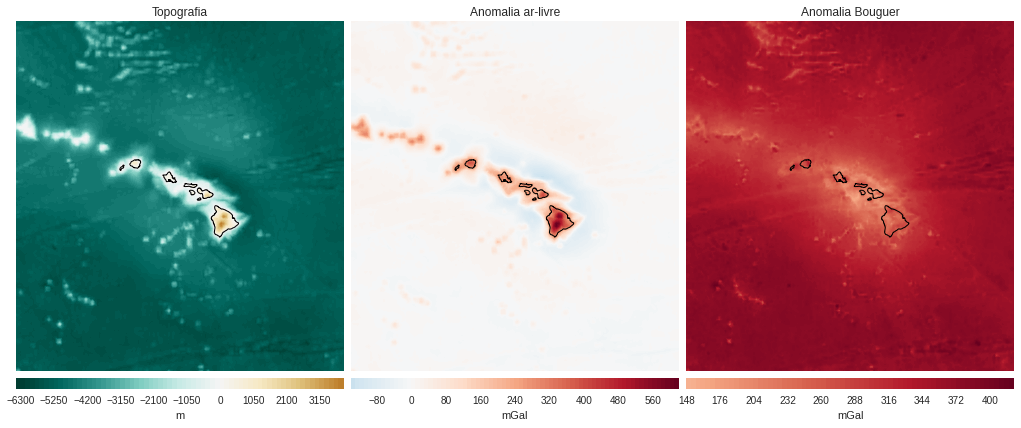

In [24]:
x, y = havai_bm(havai['longitude'], havai['latitude'])
fig, axes = plt.subplots(1, 3, figsize=(14, 9))
ax = axes[0]
tmp = havai_bm.contourf(x, y, havai['topo'], 80, tri=True, ax=ax, cmap='BrBG_r', 
                        **data_minmax(havai['topo']))
plt.colorbar(tmp, ax=ax, orientation='horizontal', pad=0.01, aspect=30, shrink=1).set_label('m')
havai_bm.drawcoastlines(ax=ax)
ax.set_title('Topografia')
ax = axes[1]
tmp = havai_bm.contourf(x, y, havai['disturbio'], 80, tri=True, ax=ax, cmap='RdBu_r', 
                        **data_minmax(havai['disturbio']))
plt.colorbar(tmp, ax=ax, orientation='horizontal', pad=0.01, aspect=30, shrink=1).set_label('mGal')
havai_bm.drawcoastlines(ax=ax)
ax.set_title('Anomalia ar-livre')
ax = axes[2]
tmp = havai_bm.contourf(x, y, havai['bouguer'], 80, tri=True, ax=ax, cmap='RdBu_r', 
                        **data_minmax(havai['bouguer']))
plt.colorbar(tmp, ax=ax, orientation='horizontal', pad=0.01, aspect=30, shrink=1).set_label('mGal')
havai_bm.drawcoastlines(ax=ax)
ax.set_title('Anomalia Bouguer')
plt.tight_layout(pad=0, w_pad=0)

Agora que temos os mapas, vamos ver como é o gráfico da **anomalia Bouguer pela topografia equivalente**.

Lembrando que a topografia equivalente é:

$$
h_{eq} = 
\begin{cases}
    h & \quad \text{if } h  \ge 0 \\
    h \frac{\rho_c - \rho_a}{\rho_c} & \quad \text{if } h < 0 \\
\end{cases}
$$

em que $h$ é a topografia, $\rho_c$ é a densidade da crosta e $\rho_a$ é a densidade da água do mar.

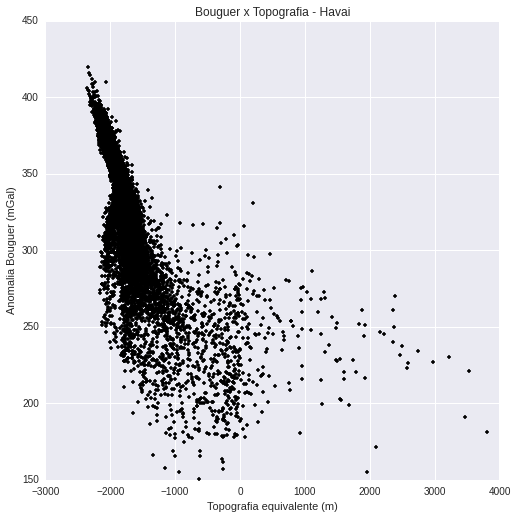

In [67]:
heq = havai['topo']
heq[heq < 0] *= (2670 - 1040)/2670
plt.figure(figsize=(7, 7))
plt.title('Bouguer x Topografia - Havai')
plt.plot(heq, havai['bouguer'], '.k')
plt.xlabel('Topografia equivalente (m)')
plt.ylabel('Anomalia Bouguer (mGal)')
plt.tight_layout(pad=0)

É muito útil olhar os dados alongo de um **perfil** que corte as principais feições dos mapas acima. Vamos estrair o perfil entre os pontos `p1` e `p2` definidos abaixo.

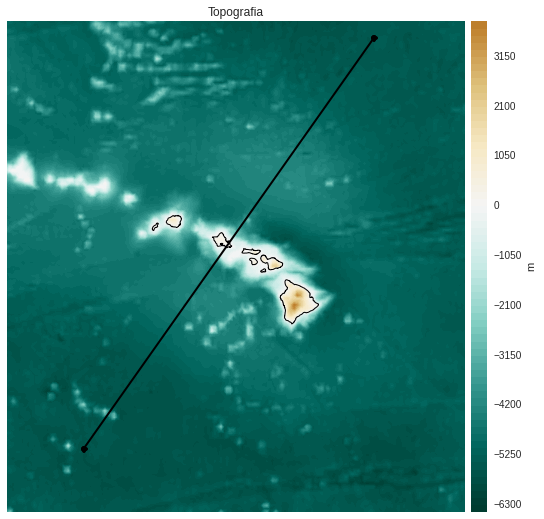

In [33]:
p1, p2 = havai_bm(197.5, 15), havai_bm(207, 27.5)

plt.figure(figsize=(8, 7))
ax = plt.subplot(111)
tmp = havai_bm.contourf(x, y, havai['topo'], 80, tri=True, ax=ax, cmap='BrBG_r', 
                        **data_minmax(havai['topo']))
plt.colorbar(tmp, ax=ax, orientation='vertical', pad=0.01, aspect=30, shrink=1).set_label('m')
havai_bm.drawcoastlines(ax=ax)
ax.set_title('Topografia')
xp, yp = np.transpose([p1, p2])
havai_bm.plot(xp, yp, 'o-k', linewidth=2)
plt.tight_layout(pad=0)

Rode a célula abaixo para extrair o perfil dos dados.

In [35]:
tmp = gridder.profile(x, y, havai['topo'], p1, p2, 100)
perfil_havai = dict(distancia=tmp[2], topo=tmp[3])
perfil_havai['bouguer'] = gridder.profile(x, y, havai['bouguer'], p1, p2, 100)[-1]
perfil_havai['disturbio'] = gridder.profile(x, y, havai['disturbio'], p1, p2, 100)[-1]

Agora podemos fazer um gráfico com os 3 dados (topografia e anomalias) ao longo do perfil.

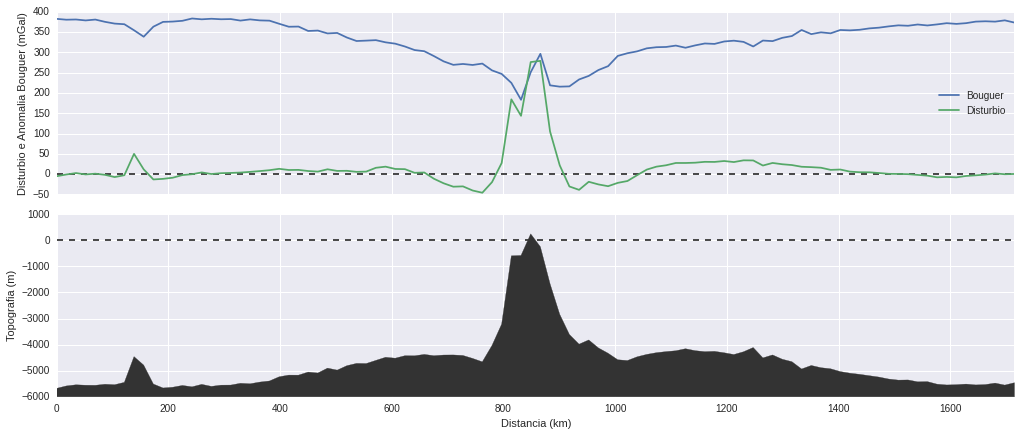

In [47]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(14, 6))
ax1, ax2 = axes
d = perfil_havai['distancia']*0.001
ax2.fill_between(d, perfil_havai['topo'], -6000, color='#333333')
ax2.hlines(0, d.min(), d.max(), linestyles='--', color='#333333')
ax2.set_ylabel('Topografia (m)')
ax2.set_xlabel('Distancia (km)')

ax1.set_ylabel('Disturbio e Anomalia Bouguer (mGal)')
ax1.plot(d, perfil_havai['bouguer'], '-', label='Bouguer')
ax1.plot(d, perfil_havai['disturbio'], '-', label='Disturbio')
ax1.hlines(0, d.min(), d.max(), linestyles='--', color='#333333')
ax1.legend(loc='center right')
ax1.set_xlim(d.min(), d.max())
plt.tight_layout(h_pad=0, pad=0)

### Para pensar

* As ilhas estão em equilíbrio isostático?
* Por que o distúrbio é positivo em cima das ilhas?
* Por que o distúrbio tem seu mínimo logo ao lado das ilhas?
* Olhando para o perfil de topografia, por que após o baixo ao lado da ilha há um alto na topografia antes de estabilizar entre -5000 m e -6000 m?
* Como e por que as feições do distúrbio se correlacionam com a topografia?
* Por que a anomalia Bouguer é sempre positiva?
* Por que a anomalia Bouguer é menos positiva sobre as ilhas?


# Japão

Vamos repetir o mesmo que fizemos antes mas para  os dados do Japão:

In [50]:
HTML('<iframe src="https://www.google.com/maps/embed?pb=!1m10!1m8!1m3!1d10208277.426130258!2d134.3822639!3d36.1346696!3m2!1i1024!2i768!4f13.1!5e1!3m2!1sen!2sbr!4v1413403088567" width="600" height="450" frameborder="0" style="border:0"></iframe>')

Primeiro, carregar os dados e calcular o distúrbio e anomalia Bouguer.

In [51]:
japao = load_icgem_gdf('../data/eigen-6c3stat-japao.gdf')
japao['topo']  = load_icgem_gdf('../data/etopo1-japao.gdf', usecols=[-1])['topography_shm']
japao['disturbio'] = japao['gravity_earth'] - normal_gravity.gamma_closed_form(japao['latitude'], japao['h_over_geoid'])
japao['bouguer'] = japao['disturbio'] - normal_gravity.bouguer_plate(japao['topo'], density_rock=2670, density_water=1040)

Vamos ver como ficam as anomalias e a topografia para essa região.

In [57]:
s, n, w, e = japao['area']
japao_bm = Basemap(projection='merc', llcrnrlat=s, urcrnrlat=n, llcrnrlon=w, urcrnrlon=e, 
                   lat_ts=0.5*(s + n), resolution='l')

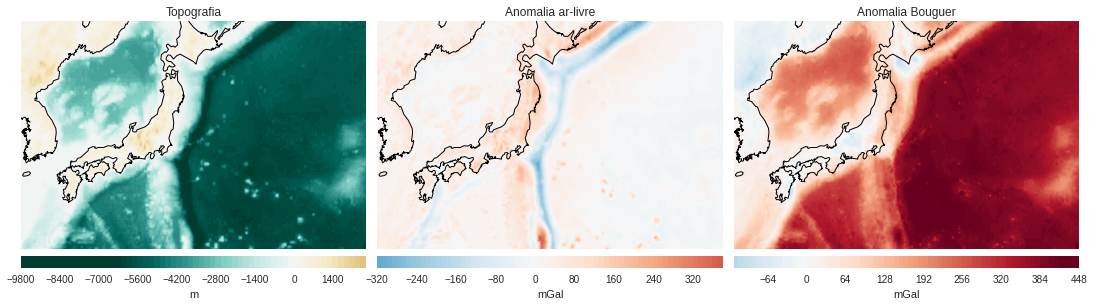

In [63]:
x, y = japao_bm(japao['longitude'], japao['latitude'])
fig, axes = plt.subplots(1, 3, figsize=(15, 10))
ax = axes[0]
tmp = japao_bm.contourf(x, y, japao['topo'], 80, tri=True, ax=ax, cmap='BrBG_r', 
                        **data_minmax(havai['topo']))
plt.colorbar(tmp, ax=ax, orientation='horizontal', pad=0.01, aspect=30, shrink=1).set_label('m')
japao_bm.drawcoastlines(ax=ax)
ax.set_title('Topografia')
ax = axes[1]
tmp = japao_bm.contourf(x, y, japao['disturbio'], 80, tri=True, ax=ax, cmap='RdBu_r', 
                        **data_minmax(havai['disturbio']))
plt.colorbar(tmp, ax=ax, orientation='horizontal', pad=0.01, aspect=30, shrink=1).set_label('mGal')
japao_bm.drawcoastlines(ax=ax)
ax.set_title('Anomalia ar-livre')
ax = axes[2]
tmp = japao_bm.contourf(x, y, japao['bouguer'], 80, tri=True, ax=ax, cmap='RdBu_r', 
                        **data_minmax(havai['bouguer']))
plt.colorbar(tmp, ax=ax, orientation='horizontal', pad=0.01, aspect=30, shrink=1).set_label('mGal')
japao_bm.drawcoastlines(ax=ax)
ax.set_title('Anomalia Bouguer')
plt.tight_layout(pad=0, w_pad=0)

Agora podemos fazer o gráfico de anomalia Bouguer por topografia equivalente.

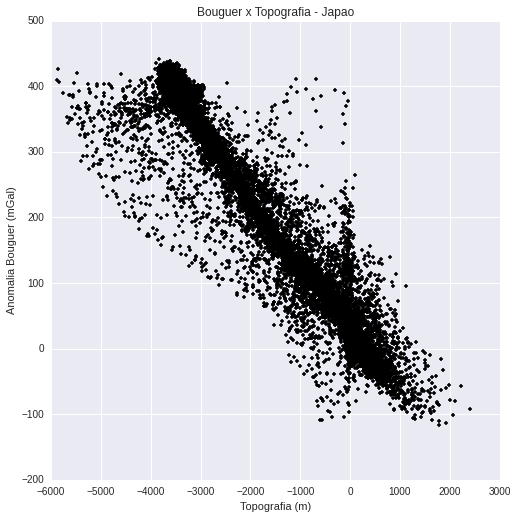

In [66]:
heq = japao['topo']
heq[heq < 0] *= (2670 - 1040)/2670
plt.figure(figsize=(7, 7))
plt.title('Bouguer x Topografia - Japao')
plt.plot(heq, japao['bouguer'], '.k')
plt.xlabel('Topografia equivalente (m)')
plt.ylabel('Anomalia Bouguer (mGal)')
plt.tight_layout(pad=0)

Vamos extrair um perfil cortando a zona de subducção, ilhas do Japão, Mar do Japão e chegando no continente.

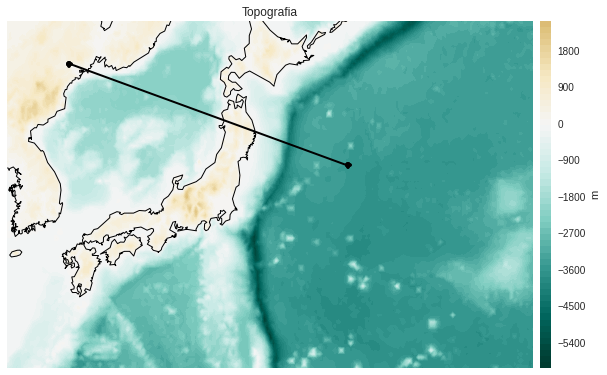

In [70]:
p1, p2 = japao_bm(130, 43), japao_bm(148, 38)

plt.figure(figsize=(9, 5))
ax = plt.subplot(111)
tmp = japao_bm.contourf(x, y, japao['topo'], 80, tri=True, ax=ax, cmap='BrBG_r', 
                        **data_minmax(japao['topo']))
plt.colorbar(tmp, ax=ax, orientation='vertical', pad=0.01, aspect=30, shrink=1).set_label('m')
japao_bm.drawcoastlines(ax=ax)
ax.set_title('Topografia')
xp, yp = np.transpose([p1, p2])
japao_bm.plot(xp, yp, 'o-k', linewidth=2)
plt.tight_layout(pad=0)

In [72]:
tmp = gridder.profile(x, y, japao['topo'], p1, p2, 100)
perfil_japao = dict(distancia=tmp[2], topo=tmp[3])
perfil_japao['bouguer'] = gridder.profile(x, y, japao['bouguer'], p1, p2, 100)[-1]
perfil_japao['disturbio'] = gridder.profile(x, y, japao['disturbio'], p1, p2, 100)[-1]

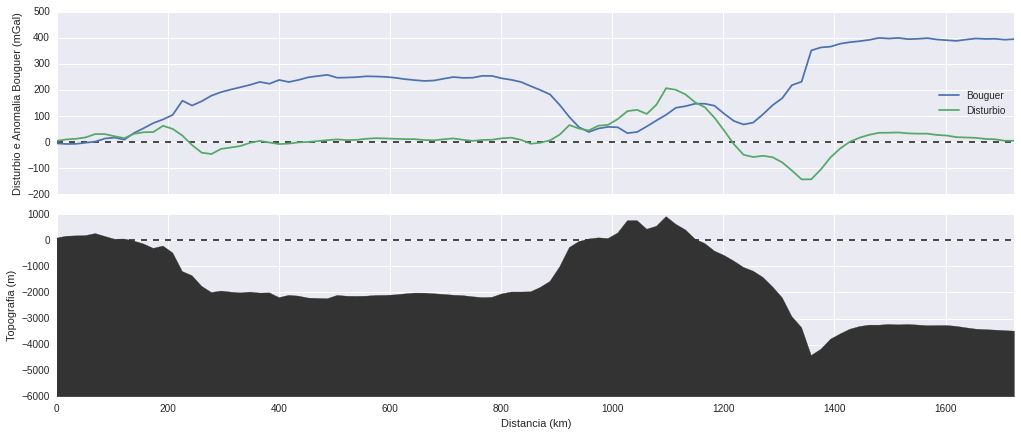

In [73]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(14, 6))
ax1, ax2 = axes
d = perfil_japao['distancia']*0.001
ax2.fill_between(d, perfil_japao['topo'], -6000, color='#333333')
ax2.hlines(0, d.min(), d.max(), linestyles='--', color='#333333')
ax2.set_ylabel('Topografia (m)')
ax2.set_xlabel('Distancia (km)')

ax1.set_ylabel('Disturbio e Anomalia Bouguer (mGal)')
ax1.plot(d, perfil_japao['bouguer'], '-', label='Bouguer')
ax1.plot(d, perfil_japao['disturbio'], '-', label='Disturbio')
ax1.hlines(0, d.min(), d.max(), linestyles='--', color='#333333')
ax1.legend(loc='center right')
ax1.set_xlim(d.min(), d.max())
plt.tight_layout(h_pad=0, pad=0)

### Para pensar

* Por que o distúrbio é praticamente zero na placa do Pacífico e no Mar do Japão?
* Por que o distúrbio apresenta um par negativo-positivo quando passamos da crosta oceânica para as ilhas do Japão?
* Qual é a relação entre o distúrbio, a topografia e a subducção?


# Andes

Fazendo a mesma coisa para os Andes, na região do [Altiplano](http://en.wikipedia.org/wiki/Altiplano) (a zona mais alta dos Andes).

In [20]:
HTML('<iframe src="https://www.google.com/maps/embed?pb=!1m10!1m8!1m3!1d11484901.000555314!2d-68.43408479478268!3d-24.6827481672861!3m2!1i1024!2i768!4f13.1!5e1!3m2!1sen!2sbr!4v1413404380586" width="600" height="450" frameborder="0" style="border:0"></iframe>')

In [21]:
andes = Grid.load('../data/eigen-6c3stat-andes.gdf', column_names=['lon', 'lat', 'height', 'gravity'])
andes.add_attribute('topo', Grid.load('../data/etopo1-andes.gdf').topography_shm)
andes.set_projection(crs.Geodetic())

In [22]:
andes.dump_csv('../data/andes.csv')
!sed -i 's/\./\,/g' ../data/andes.csv

In [23]:
andes.add_attribute('arlivre', andes.gravity - gravidade_normal_em_p(andes.lat, andes.height))
andes.add_attribute('bouguer', andes.arlivre - plato_bouguer(andes.topo, 2670, 1000))

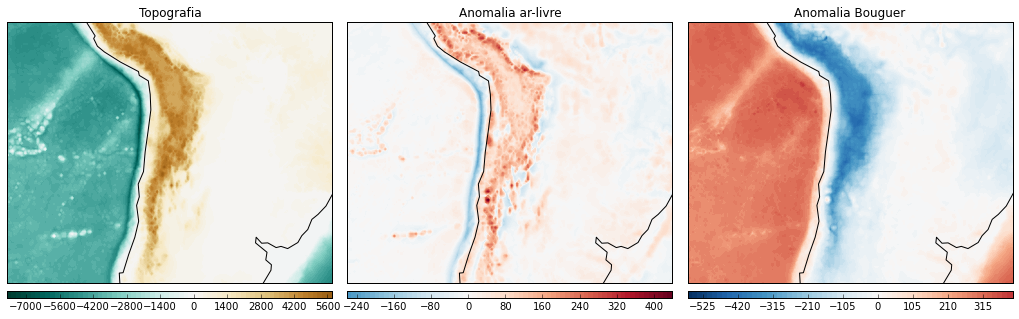

In [24]:
proj = andes.reproject(crs.Mercator())
fig, axes = mpl.subplots(1, 3, figsize=(14, 6), subplot_kw=dict(projection=proj.projection))
ax = axes[0]
proj.contourf('topo', levels=80, colorbar='horizontal', ax=ax, cmap=mpl.cm.BrBG_r)
ax.coastlines()
ax.set_title('Topografia')
ax = axes[1]
proj.contourf('arlivre', levels=80, colorbar='horizontal', ax=ax)
ax.coastlines()
ax.set_title('Anomalia ar-livre')
ax = axes[2]
proj.contourf('bouguer', levels=80, colorbar='horizontal', ax=ax)
ax.coastlines()
ax.set_title('Anomalia Bouguer')
mpl.tight_layout(pad=0, w_pad=0)

O perfil que vamos extrair corta a zona de subducção e a parte mais espessa dos Andes, terminando quase no pantanal.

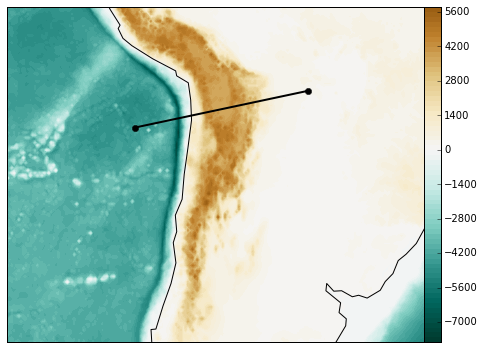

In [25]:
p1, p2 = [-22, 285], [-19, 300]

mpl.figure(figsize=(9, 6))
proj.contourf('topo', levels=80, cmap=mpl.cm.BrBG_r)
ax = mpl.gca()
ax.coastlines()
x, y = np.transpose([p1, p2])
ax.plot(y, x, 'o-k', linewidth=2, transform=crs.Geodetic())

In [26]:
perfil = andes.reproject(crs.Mercator()).profile(p1, p2, 200, projection=crs.Geodetic())

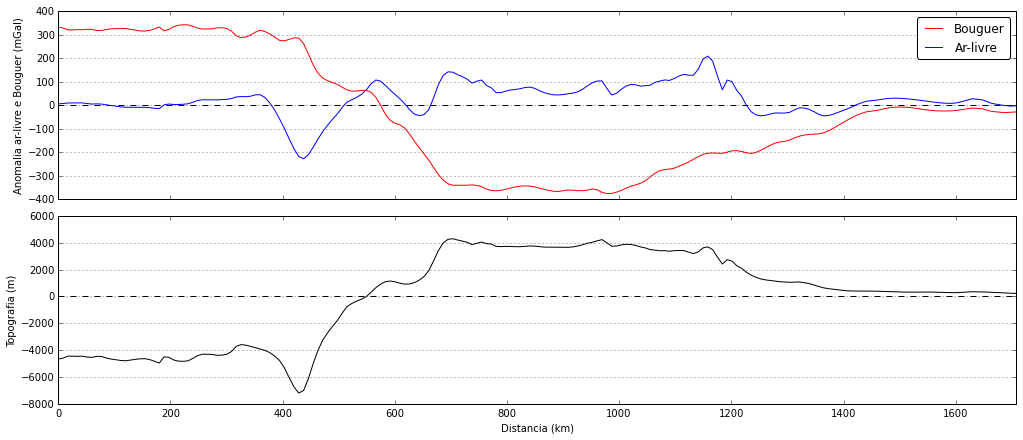

In [27]:
fig, axes = mpl.subplots(2, 1, sharex=True, figsize=(14, 6))
ax1, ax2 = axes
d = perfil.distance*0.001
ax2.plot(d, perfil.topo, '-k')
ax2.hlines(0, d.min(), d.max(), linestyles='--')
ax2.set_ylabel('Topografia (m)')
ax2.set_xlabel('Distancia (km)')
ax2.grid(axis='y')

ax1.set_ylabel('Anomalia ar-livre e Bouguer (mGal)')
ax1.plot(d, perfil.bouguer, '-r', label='Bouguer')
ax1.plot(d, perfil.arlivre, '-b', label='Ar-livre')
ax1.hlines(0, d.min(), d.max(), linestyles='--')
ax1.legend(loc='upper right', fancybox=True)
ax1.grid(axis='y')
ax1.set_xlim(d.min(), d.max())
mpl.tight_layout(h_pad=0, pad=0)

Perguntas:

* Por que a anomalia ar-livre tem seu minimo na fossa (onde está acontecendo a subducção)?
* Por que a anomalia Bouguer é fortemente negativa na região das montanhas?

# Extra: Hudson Bay

Como um extra, vamos olhar como ficam as anomalias na região da Baía de Hudson, no Norte do Canadá:

In [28]:
HTML('<iframe src="https://www.google.com/maps/embed?pb=!1m10!1m8!1m3!1d12110458.266253604!2d-85.99188428241526!3d61.3758016298575!3m2!1i1024!2i768!4f13.1!5e1!3m2!1sen!2sbr!4v1413404706398" width="600" height="450" frameborder="0" style="border:0"></iframe>')

In [29]:
hudson = Grid.load('../data/eigen-6c3stat-hudson.gdf', column_names=['lon', 'lat', 'height', 'gravity'])
hudson.add_attribute('topo', Grid.load('../data/etopo1-hudson.gdf').topography_shm)
hudson.set_projection(crs.Geodetic())

In [30]:
hudson.dump_csv('../data/hudson.csv')
!sed -i 's/\./\,/g' ../data/hudson.csv

In [31]:
hudson.add_attribute('arlivre', hudson.gravity - gravidade_normal_em_p(hudson.lat, hudson.height))
hudson.add_attribute('bouguer', hudson.arlivre - plato_bouguer(hudson.topo, 2670, 1000))

Dessa vez, vamos usar uma [projeção polar esterográfica](http://en.wikipedia.org/wiki/Stereographic_projection) para fazer os mapas. 
A projeção Mercator distorce demais as regiões de altas latitudes.
Nesses casos, as [projeções cônicas](http://en.wikipedia.org/wiki/Map_projection#Conic) são melhores.

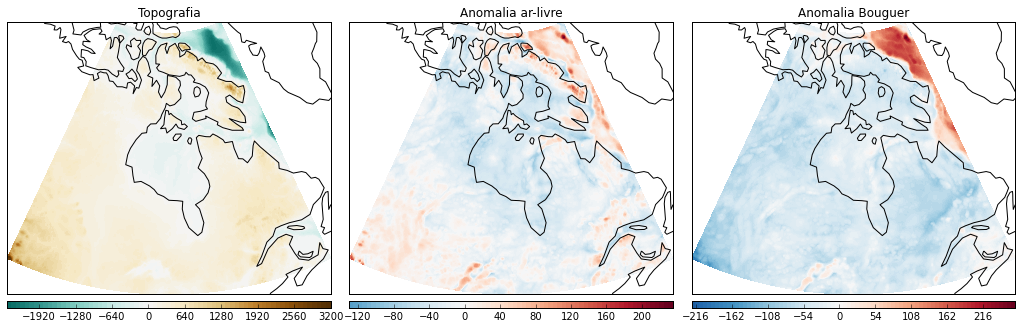

In [32]:
proj = hudson.reproject(crs.NorthPolarStereo(central_longitude=np.mean(hudson.area[2:])))
fig, axes = mpl.subplots(1, 3, figsize=(14, 5), subplot_kw=dict(projection=proj.projection))
ax = axes[0]
proj.contourf('topo', levels=80, colorbar='horizontal', ax=ax, cmap=mpl.cm.BrBG_r)
ax.coastlines()
ax.set_title('Topografia')
ax = axes[1]
proj.contourf('arlivre', levels=80, colorbar='horizontal', ax=ax)
ax.coastlines()
ax.set_title('Anomalia ar-livre')
ax = axes[2]
proj.contourf('bouguer', levels=80, colorbar='horizontal', ax=ax)
ax.coastlines()
ax.set_title('Anomalia Bouguer')
mpl.tight_layout(pad=0, w_pad=0)

O perfil que vamos extrair vai do continente ao mar do Norte, cortando a baía.

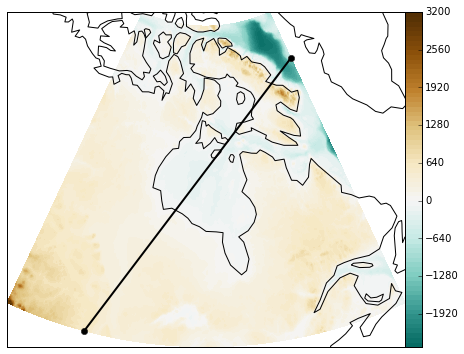

In [33]:
p1, p2 = [45, 260], [70, 300]

mpl.figure(figsize=(9, 6))
proj.contourf('topo', levels=80, cmap=mpl.cm.BrBG_r)
ax = mpl.gca()
ax.coastlines()
x, y = np.transpose([p1, p2])
ax.plot(y, x, 'o-k', linewidth=2, transform=crs.Geodetic())

In [34]:
perfil = proj.profile(p1, p2, 200, projection=crs.Geodetic())

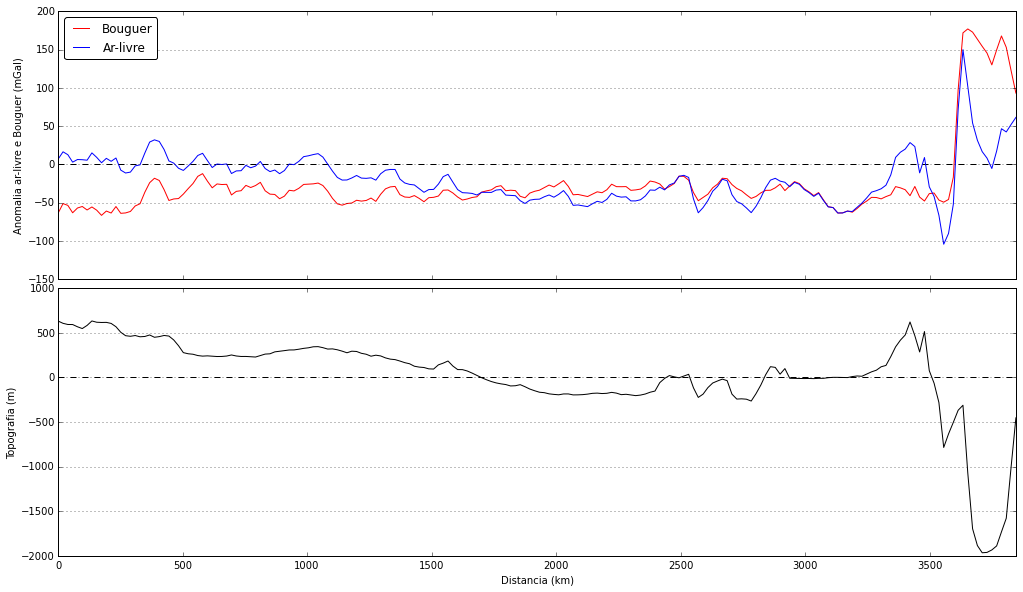

In [35]:
fig, axes = mpl.subplots(2, 1, sharex=True, figsize=(14, 8))
ax1, ax2 = axes
d = perfil.distance*0.001
ax2.plot(d, perfil.topo, '-k')
ax2.hlines(0, d.min(), d.max(), linestyles='--')
ax2.set_ylabel('Topografia (m)')
ax2.set_xlabel('Distancia (km)')
ax2.grid(axis='y')

ax1.set_ylabel('Anomalia ar-livre e Bouguer (mGal)')
ax1.plot(d, perfil.bouguer, '-r', label='Bouguer')
ax1.plot(d, perfil.arlivre, '-b', label='Ar-livre')
ax1.hlines(0, d.min(), d.max(), linestyles='--')
ax1.legend(loc='upper left', fancybox=True)
ax1.grid(axis='y')
ax1.set_xlim(d.min(), d.max())
mpl.tight_layout(h_pad=0, pad=0)

Perguntas:

* Esta região está em equilíbrio isostático?
* O que significa a anomalia Bouguer ser praticamente constante (na média) ao longo do perfil?
* Por que a anomalia ar-livre fica cada vez mais negativa quando mais progredimos para o Norte do perfil?

